In [ ]:
# kaggle.json 파일 업로드
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sohnminhee","key":"ce2fcca713d6eaa56397dc2616383431"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d techsash/waste-classification-data

 98% 417M/427M [00:01<00:00, 279MB/s]
100% 427M/427M [00:01<00:00, 237MB/s]


In [ ]:
!unzip waste-classification-data.zip


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  inflating: datas

In [ ]:
!ls


dataset  DATASET  drive  kaggle.json  sample_data  waste-classification-data.zip


In [ ]:
data_dir = "/content/DATASET/TRAIN"



Number of Organic Images:  12565
Number of Recyclable Images:  9999


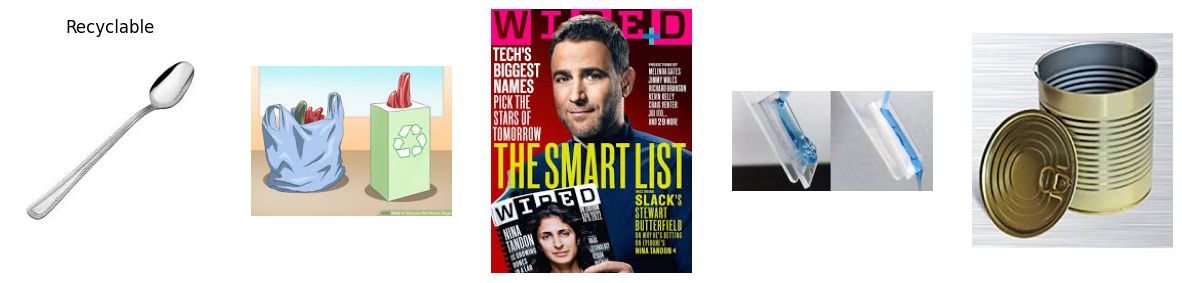

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

data_dir = "/content/DATASET/TRAIN"

# 이미지 경로 가져오기
organic_paths = [os.path.join(data_dir, 'O', img) for img in os.listdir(os.path.join(data_dir, 'O')) if img.endswith('.jpg')]
recyclable_paths = [os.path.join(data_dir, 'R', img) for img in os.listdir(os.path.join(data_dir, 'R')) if img.endswith('.jpg')]

# 라벨 분포 확인
print("Number of Organic Images: ", len(organic_paths))
print("Number of Recyclable Images: ", len(recyclable_paths))

# 몇몇 이미지 시각화
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for ax, img_path in zip(axes, np.random.choice(organic_paths, 5)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
axes[0].set_title('Organic')
for ax, img_path in zip(axes, np.random.choice(recyclable_paths, 5)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
axes[0].set_title('Recyclable')
plt.show()


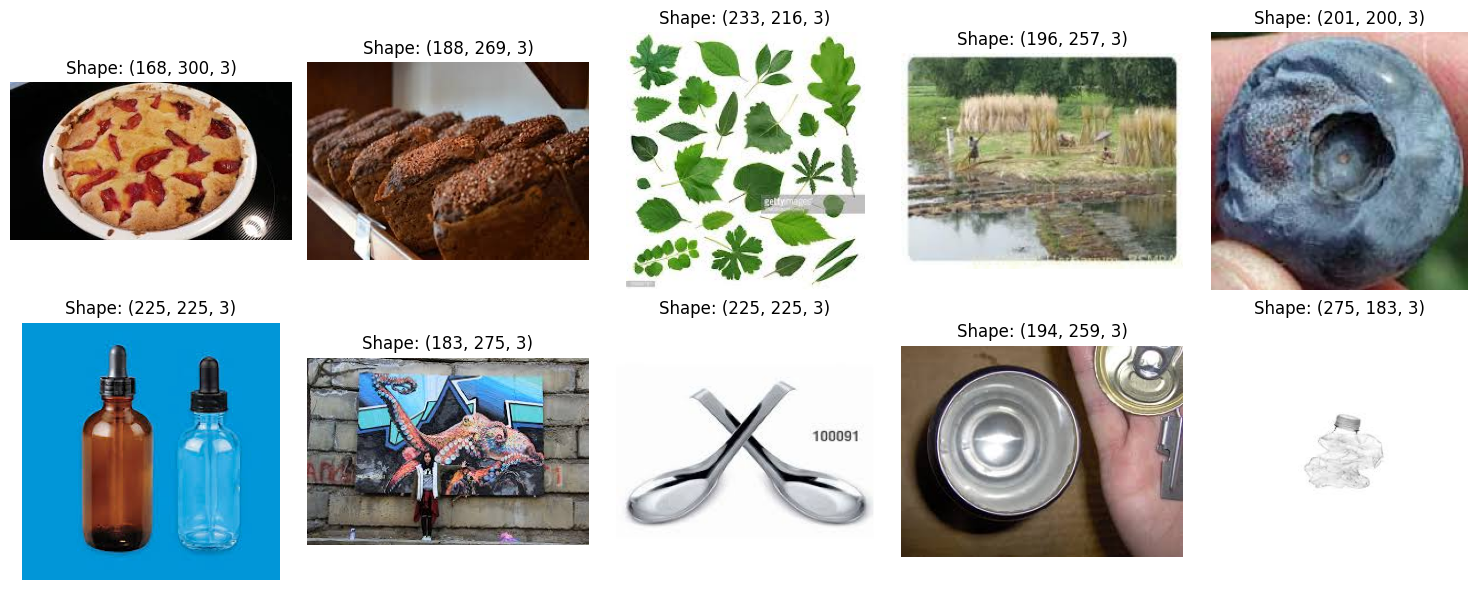

In [ ]:
# 몇몇 이미지 시각화 및 크기 확인
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, img_path in zip(axes[0], np.random.choice(organic_paths, 10)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Shape: {img.shape}")
axes[0, 0].set_ylabel('Organic')

for ax, img_path in zip(axes[1], np.random.choice(recyclable_paths, 10)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Shape: {img.shape}")
axes[1, 0].set_ylabel('Recyclable')
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 크기와 배치 크기 설정
img_size = (224, 224)
batch_size = 32

# 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 검증 데이터를 20% 사용
)

test_datagen = ImageDataGenerator(rescale=1./255)  # 테스트 데이터에는 증강을 적용하지 않음


In [ ]:
# 학습, 검증 및 테스트 데이터셋을 위한 배치 생성기 설정
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # 학습 데이터
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # 검증 데이터
)

# 테스트 데이터셋 경로 설정 (필요한 경우)
test_data_dir = "/content/DATASET/TEST"
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)



Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# 사전에 학습된 MobileNetV2 모델 로드
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모델의 모든 층을 학습 불가능하도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 커스텀 층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# 최종 모델 구축
model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/10
564/564 [==============================] - 313s 534ms/step - loss: 0.2414 - accuracy: 0.9069 - val_loss: 0.1892 - val_accuracy: 0.9271
Epoch 2/10
564/564 [==============================] - 297s 527ms/step - loss: 0.1731 - accuracy: 0.9346 - val_loss: 0.1758 - val_accuracy: 0.9337
Epoch 3/10
564/564 [==============================] - 297s 527ms/step - loss: 0.1513 - accuracy: 0.9415 - val_loss: 0.1888 - val_accuracy: 0.9306
Epoch 4/10
564/564 [==============================] - 297s 528ms/step - loss: 0.1411 - accuracy: 0.9438 - val_loss: 0.1803 - val_accuracy: 0.9342
Epoch 5/10
564/564 [==============================] - 317s 563ms/step - loss: 0.1309 - accuracy: 0.9488 - val_loss: 0.1703 - val_accuracy: 0.9364
Epoch 6/10
564/564 [==============================] - 292s 518ms/step - loss: 0.1177 - accuracy: 0.9543 - val_loss: 0.1816 - val_accuracy: 0.9324
Epoch 7/10
564/564 [==============================] - 291s 517ms/step - loss: 0.1142 - accuracy: 0.9563 - val_loss: 0.1765 -

In [ ]:
# 모델을 테스트 데이터셋에서 평가합니다.
# 'evaluate' 함수는 손실과 정확도를 반환합니다.
evaluation = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

# 테스트 데이터셋에 대한 손실과 정확도를 출력합니다.
print("테스트 데이터셋 손실: {:.4f}".format(evaluation[0]))
print("테스트 데이터셋 정확도: {:.4f}".format(evaluation[1]))


78/78 [==============================] - 5s 57ms/step - loss: 0.4332 - accuracy: 0.8149
테스트 데이터셋 손실: 0.4332
테스트 데이터셋 정확도: 0.8149


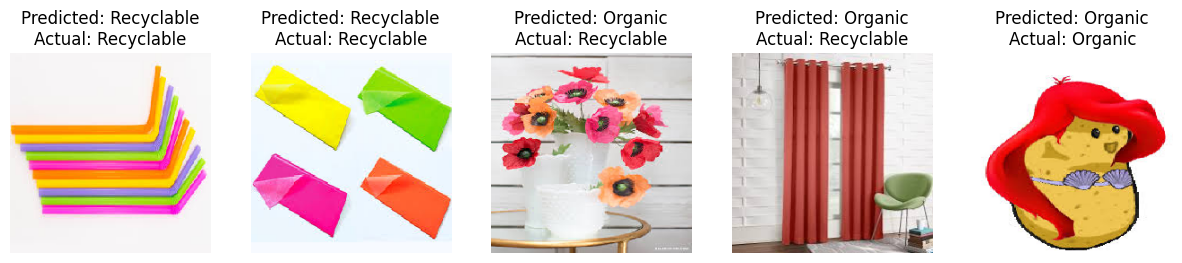

In [ ]:
# 레이블을 문자열로 변환하는 함수
def label_to_str(label, threshold=0.7):
    return "Recyclable" if label > threshold else "Organic"

# 이미지와 예측 결과를 시각화합니다.
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].set_title("Predicted: {}\nActual: {}".format(label_to_str(predictions[i][0]), label_to_str(labels[i])))
    axes[i].axis('off')
plt.show()


1/1 [==============================] - 0s 32ms/step


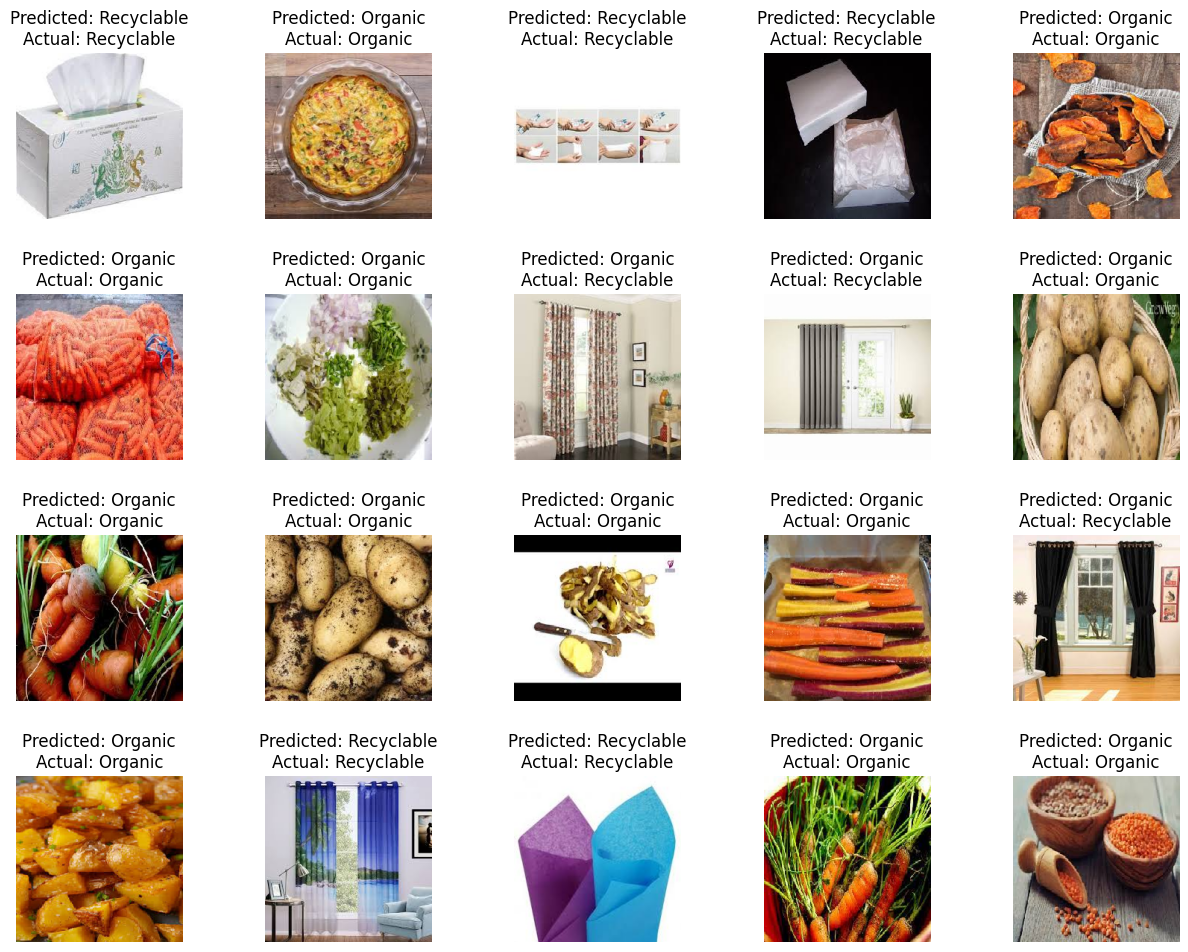

In [ ]:
# 테스트 데이터셋에서 이미지 배치를 가져옵니다. (배치 사이즈를 20으로 설정)
images, labels = test_generator.next()

# 모델을 사용하여 예측을 수행합니다.
predictions = model.predict(images)

# 이미지와 예측 결과를 시각화합니다.
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))  # 4x5 그리드로 설정
axes = axes.ravel()
for i in np.arange(0, 20):  # 20개의 이미지를 표시
    axes[i].imshow(images[i])
    axes[i].set_title("Predicted: {}\nActual: {}".format(label_to_str(predictions[i][0]), label_to_str(labels[i])))
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 모델을 저장할 경로 설정
model_save_path = '/content/drive/My Drive/waste_classifier_model.h5'

# 모델 저장
model.save(model_save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

# 저장된 Keras 모델의 경로를 지정합니다.
saved_keras_model_path = '/content/drive/My Drive/waste_classifier_model.h5'

# Keras 모델을 불러옵니다.
model = tf.keras.models.load_model(saved_keras_model_path)

# TensorFlow Lite Converter를 사용하여 모델을 변환합니다.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 변환된 모델을 파일로 저장할 경로를 지정합니다.
tflite_model_path = '/content/drive/My Drive/waste_classifier_model.tflite'

# 변환된 모델을 파일로 저장합니다.
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
